3: Writing and including custom Effects
=======================================

In this tutorial, we will load the model of MICADO (including Armazones, ELT, MAORY) and then turn off all effect that modify the spatial extent of the stars. The purpose here is to see in detail what happens to the **distribution of the stars flux on a sub-pixel level** when we add a plug-in astrometric Effect to the optical system.

For real simulation, we will obviously leave all normal MICADO effects turned on, while still adding the plug-in Effect. Hopefully this tutorial will serve as a refernce for those who want to see **how to create Plug-ins** and how to manipulate the effects in the MICADO optical train model.


Create and optical model for MICADO and the ELT
-----------------------------------------------

In [1]:
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import scopesim as sim
from scopesim_templates.stellar import stars, star_grid

Scopesim works by using so-called instrument packages, which have to be downloaded separately. For normal use, you would set the package directory (a local folder path, `local_package_folder` in this example), download the required packages *once*, and then **remove the download command**.

In [2]:
local_package_folder = "./inst_pkgs"

However, to be able to run this example on the *Readthedocs* page, we need to include a temporary directory.

**Do not** copy and run this code locally, it is **only** needed to set things up for *Readthedocs*!

In [3]:
from tempfile import TemporaryDirectory
local_package_folder = TemporaryDirectory().name

Download the required instrument packages for an observation with MICADO at the ELT.

Again, you would only need to do this **once**, not every time you run the rest of the script, assuming you set a (permanent) instrument package folder.

In [4]:
sim.download_packages(["Armazones", "ELT", "MICADO", "MAORY"])

['C:\\Users\\ghost\\Desktop\\PhD\\ScopeSim\\docs\\source\\examples\\inst_pkgs\\Armazones.zip',
 'C:\\Users\\ghost\\Desktop\\PhD\\ScopeSim\\docs\\source\\examples\\inst_pkgs\\ELT.zip',
 'C:\\Users\\ghost\\Desktop\\PhD\\ScopeSim\\docs\\source\\examples\\inst_pkgs\\MICADO.zip',
 'C:\\Users\\ghost\\Desktop\\PhD\\ScopeSim\\docs\\source\\examples\\inst_pkgs\\MAORY.zip']

We can see which Effects are already included by calling ``micado.effects``:

In [5]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "IMG_1.5mas"])
micado = sim.OpticalTrain(cmd)

micado.effects

element,name,class,included
str13,str23,str31,bool
armazones,skycalc_atmosphere,SkycalcTERCurve,True
ELT,telescope_reflection,SurfaceList,True
MICADO,micado_static_surfaces,SurfaceList,True
MICADO,micado_ncpas_psf,NonCommonPathAberration,True
MICADO,filter_wheel_1 : [open],FilterWheel,True
MICADO,filter_wheel_2 : [Ks],FilterWheel,True
MICADO,pupil_wheel : [open],FilterWheel,True
MICADO_DET,full_detector_array,DetectorList,False
MICADO_DET,detector_window,DetectorWindow,True


Now we turn off all ``Effects`` that cause spatial aberrations:

In [6]:
for effect_name in ["full_detector_array", "micado_adc_3D_shift", 
                    "micado_ncpas_psf", "relay_psf"]:
    micado[effect_name].include = False
    print(micado[effect_name])

DetectorList: "full_detector_array"
AtmosphericDispersionCorrection: "micado_adc_3D_shift"
NonCommonPathAberration: "micado_ncpas_psf"
FieldConstantPSF: "relay_psf"


The normal detector window is set to 1024 pixels square.
Let's reduce the size of the detector readout window:

In [7]:
micado["detector_window"].data["x_cen"] = 0          # [mm] distance from optical axis on the focal plane
micado["detector_window"].data["y_cen"] = 0
micado["detector_window"].data["x_size"] = 64          # [pixel] width of detector
micado["detector_window"].data["y_size"] = 64

By default ScopeSim works on the whole pixel level for saving computation time.
However it is capable of integrating sub pixel shift.
For this we need to turn on the sub-pixel mode:

In [8]:
micado.cmds["!SIM.sub_pixel.flag"] = True

We can test what's happening by making a grid of stars and observing them:

['A0V']


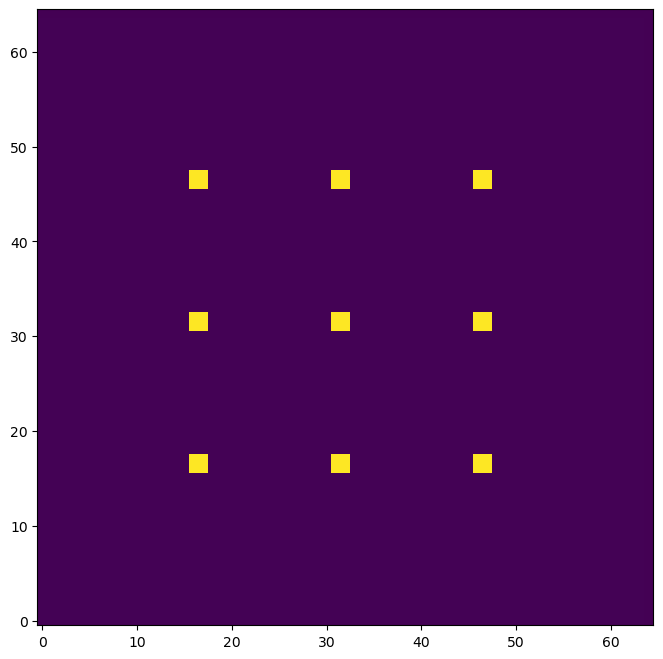

In [9]:
src = star_grid(n=9, mmin=20, mmax=20.0001, separation=0.0015 * 15)
src.fields[0]["x"] -= 0.00075
src.fields[0]["y"] -= 0.00075

micado.observe(src, update=True)

plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")

In [10]:
micado["detector_window"].data

id,x_cen,y_cen,x_size,y_size,angle,gain,pixel_size
int32,str6,str6,str10,str11,int32,int32,float64
0,0,0,64,64,0,1,0.015


Writing a custom Effect object
------------------------------

The following code snippet creates a new ``Effect`` class.
    

In [11]:
import numpy as np
from astropy.table import Table

from scopesim.effects import Effect
from scopesim.base_classes import SourceBase


class PointSourceJitter(Effect):
    def __init__(self, **kwargs):
        super(PointSourceJitter, self).__init__(**kwargs)   # initialise the underlying Effect class object
        self.meta["z_order"] = [500]                        # z_order number for knowing when and how to apply the Effect
        self.meta["max_jitter"] = 0.001                     # [arcsec] - a parameter needed by the effect
        self.meta.update(kwargs)                            # add any extra parameters passed when initialising

    def apply_to(self, obj):                                # the function that does the work
        if isinstance(obj, SourceBase):
            for field in obj.fields:
                if isinstance(field, Table):
                    dx, dy = 2 * (np.random.random(size=(2, len(field))) - 0.5)
                    field["x"] += dx * self.meta["max_jitter"]
                    field["y"] += dy * self.meta["max_jitter"]

        return obj

Lets break it down a bit (**THIS IS JUST A STEP-BY-STEP EXPLANATION OF THE CODE ABOVE, NOT SOMETHING NEW!**):

    class PointSourceJitter(Effect):
        ...

Here we are subclassing the ``Effect`` object from ScopeSim.
This has the basic functionality for reading in ASCII and FITS files, and for communicating with the ``OpticsManager`` class in ScopeSim.

The initialisation function looks like this:

    def __init__(self, **kwargs):
        super(PointSourceJitter, self).__init__(**kwargs)   # initialise the underlying Effect class object
        self.meta["z_order"] = [500]

Here we make sure to activate the underlying Effect object.
The ``z_order`` keyword in the meta dictionary is used by ScopeSim to determine when and where this Effect should be applied during a simulations run.
The exact z-order numbers are described in [insert link here].

The main function of any Effect is the ``apply_to`` method:

    def apply_to(self, obj):
        if isinstance(obj, SourceBase):
            ...

        return obj

It should be noted that what is passed in via (``obj``) must be returned in the same format. The contents of the ``obj`` can change, but the ``obj`` object must be returned.

All the code which enacts the results of the physical effect are contained in this method.
For example, if we are writing a redshifting Effect, we could write the code to shift the wavelength array of a ``Source`` object by ``z+1`` here.

There are 4 main classes that are cycled through during an observation run:
* ``SourceBase``: contains the original 2+1D distribtion of light,
* ``FieldOfViewBase``: contains a (quasi-)monochromatic cutout from the Source object,
* ``ImagePlaneBase``: contains the expectation flux image on the detector plane
* ``DetectorBase``: contains the electronic readout image

An ``Effect`` object can be applied to any number of objects based on one or more of these base classes.
Just remember to segregate the base-class-specific code with ``if`` statements.

One further method should be mentioned: ``def fov_grid()``.
This method is used by ``FOVManager`` to estimate how many ``FieldOfView`` objects to generate in order to best simulation the observation.
If your Effect object might alter this estimate, then you should include this method in your class. See the code base for further details.

**Note**: The ``fov_grid`` method will be depreciated in a future release of ScopeSim.
    It will most likely be replaced by a ``FOVSetupBase`` class that will be cycled through the ``apply_to`` function.
    However this is not yet 100% certain, so please bear with us.

Including a custom Effect
-------------------------

First we need to initialise an instance of the Effect object:

In [12]:
jitter_effect = PointSourceJitter(max_jitter=0.001, name="random_jitter")

Then we can add it to the optical model:

In [13]:
micado.optics_manager.add_effect(jitter_effect)

micado.effects

element,name,class,included
str13,str23,str31,bool
armazones,skycalc_atmosphere,SkycalcTERCurve,True
armazones,random_jitter,PointSourceJitter,True
ELT,telescope_reflection,SurfaceList,True
MICADO,micado_static_surfaces,SurfaceList,True
MICADO,micado_ncpas_psf,NonCommonPathAberration,False
MICADO,filter_wheel_1 : [open],FilterWheel,True
MICADO,filter_wheel_2 : [Ks],FilterWheel,True
MICADO,pupil_wheel : [open],FilterWheel,True
MICADO_DET,full_detector_array,DetectorList,False


When we want to observe, we need to include the ``update=True`` flag so that the optical model is updated to include the instance of our new ``Effect``:


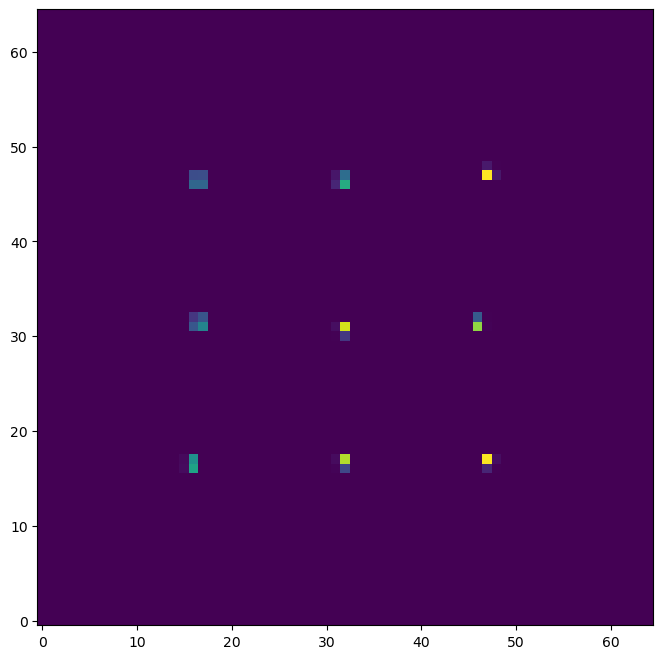

In [14]:
micado.observe(src, update=True)

plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")

We can update the parameters of the object on-the-fly by accessing the meta dictionary:

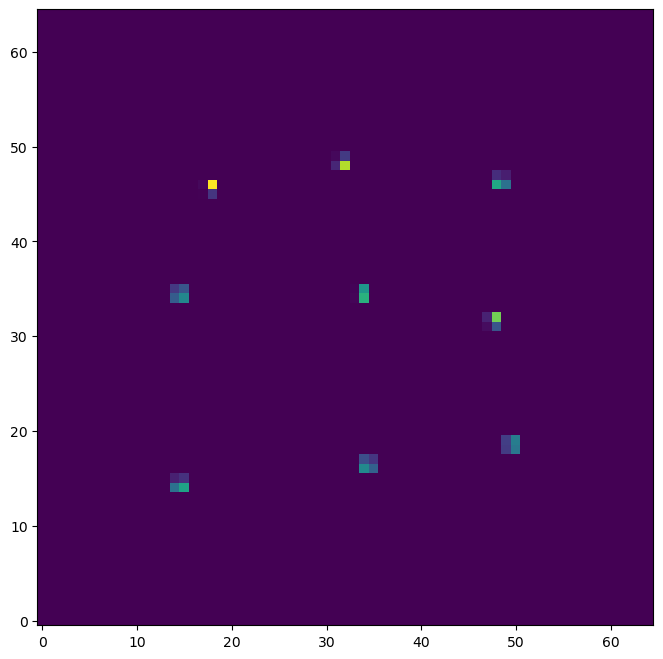

In [15]:
micado["random_jitter"].meta["max_jitter"] = 0.005

micado.observe(src, update=True)

plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")

Here we can see that there is a certain amount of sub-pixel jitter being introduced into each observation.
However this bare-bones approach is not very realistic.
We should therefore turn the PSF back on to get a more realistic observation:

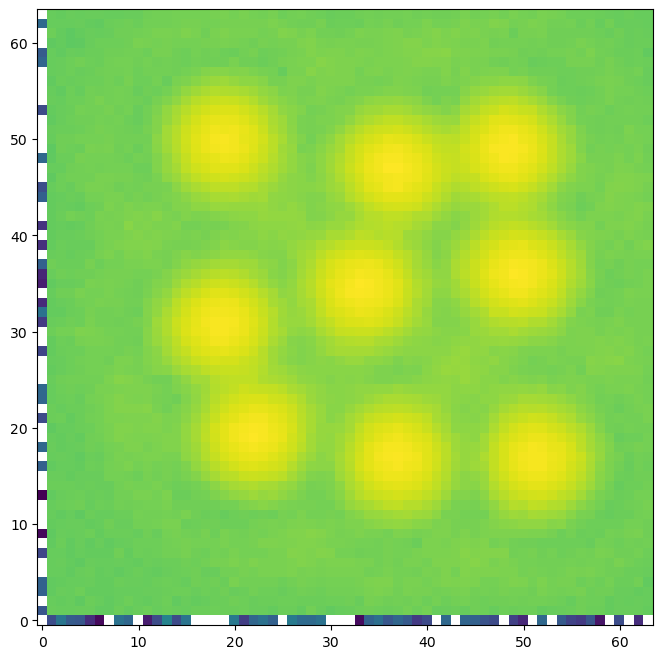

In [16]:
micado["relay_psf"].include = True

micado.observe(src, update=True)
hdus = micado.readout()

plt.figure(figsize=(8,8))
plt.imshow(hdus[0][1].data, origin="lower", norm=LogNorm())